In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import json
from datetime import datetime
import tqdm

# Import our custom modules
from ann import NeuralNetwork
from pso import PSO
from pso_ann_trainer import rmse, create_fitness_function, to_numpy

# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✅ All imports successful!")

✅ All imports successful!


## Section 1: Load Data

In [39]:
# Load data
repo_root = Path.cwd().parent  # Go up one level from src to repo root
data_dir = repo_root / 'data'
npz_path = data_dir / 'processed_data.npz'

print(f"📂 Loading data from {npz_path}...")
data = np.load(npz_path, allow_pickle=True)
X_train = to_numpy(data['X_train'])
X_test = to_numpy(data['X_test'])
y_train = to_numpy(data['y_train']).ravel()
y_test = to_numpy(data['y_test']).ravel()

print(f"✓ Training data: {X_train.shape}")
print(f"✓ Test data: {X_test.shape}")
print(f"✓ n_features: {X_train.shape[1]}")

📂 Loading data from /Users/gayathridinesh/Documents/GitHub/F21BC_Coursework/data/processed_data.npz...
✓ Training data: (824, 8)
✓ Test data: (206, 8)
✓ n_features: 8


## Section 2: Define Experiment Configurations

10 experiments with varying PSO and ANN parameters

In [40]:
n_features = X_train.shape[1]

experiment_configs = [
    {
        "exp_id": 1,
        "seed": 42,
        "layer_sizes": [n_features, 128, 64, 32, 1],
        "activations": ['relu', 'relu', 'relu', 'linear'],
        "pso_swarm_size": 25,
        "pso_iterations": 50,
        "pso_bounds": (-5.0, 5.0)
    },
    {
        "exp_id": 2,
        "seed": 123,
        "layer_sizes": [n_features, 256, 128, 64, 32, 1],
        "activations": ['relu', 'relu', 'relu', 'relu', 'linear'],
        "pso_swarm_size": 30,
        "pso_iterations": 60,
        "pso_bounds": (-4.0, 4.0)
    },
    {
        "exp_id": 3,
        "seed": 456,
        "layer_sizes": [n_features, 200, 150, 100, 50, 1],
        "activations": ['relu', 'relu', 'relu', 'relu', 'linear'],
        "pso_swarm_size": 35,
        "pso_iterations": 70,
        "pso_bounds": (-3.5, 3.5)
    },
    {
        "exp_id": 4,
        "seed": 789,
        "layer_sizes": [n_features, 300, 200, 128, 64, 32, 1],
        "activations": ['relu', 'relu', 'relu', 'relu', 'relu', 'linear'],
        "pso_swarm_size": 40,
        "pso_iterations": 80,
        "pso_bounds": (-3.0, 3.0)
    },
    {
        "exp_id": 5,
        "seed": 999,
        "layer_sizes": [n_features, 250, 200, 150, 100, 50, 1],
        "activations": ['relu', 'relu', 'relu', 'relu', 'relu', 'linear'],
        "pso_swarm_size": 38,
        "pso_iterations": 75,
        "pso_bounds": (-3.0, 3.0)
    },
    {
        "exp_id": 6,
        "seed": 111,
        "layer_sizes": [n_features, 180, 120, 80, 40, 1],
        "activations": ['relu', 'relu', 'relu', 'relu', 'linear'],
        "pso_swarm_size": 32,
        "pso_iterations": 65,
        "pso_bounds": (-4.0, 4.0)
    },
    {
        "exp_id": 7,
        "seed": 222,
        "layer_sizes": [n_features, 160, 128, 96, 64, 32, 1],
        "activations": ['relu', 'relu', 'relu', 'relu', 'relu', 'linear'],
        "pso_swarm_size": 36,
        "pso_iterations": 72,
        "pso_bounds": (-3.5, 3.5)
    },
    {
        "exp_id": 8,
        "seed": 333,
        "layer_sizes": [n_features, 224, 168, 112, 56, 1],
        "activations": ['relu', 'relu', 'relu', 'relu', 'linear'],
        "pso_swarm_size": 33,
        "pso_iterations": 68,
        "pso_bounds": (-3.5, 3.5)
    },
    {
        "exp_id": 9,
        "seed": 444,
        "layer_sizes": [n_features, 320, 240, 160, 80, 40, 1],
        "activations": ['relu', 'relu', 'relu', 'relu', 'relu', 'linear'],
        "pso_swarm_size": 42,
        "pso_iterations": 85,
        "pso_bounds": (-2.8, 2.8)
    },
    {
        "exp_id": 10,
        "seed": 555,
        "layer_sizes": [n_features, 192, 144, 108, 72, 36, 1],
        "activations": ['relu', 'relu', 'relu', 'relu', 'relu', 'linear'],
        "pso_swarm_size": 39,
        "pso_iterations": 78,
        "pso_bounds": (-3.2, 3.2)
    }
]

print(f"📋 Configured {len(experiment_configs)} experiments")
for cfg in experiment_configs:
    print(f"  Exp {cfg['exp_id']}: layers={cfg['layer_sizes']}, swarm={cfg['pso_swarm_size']}, iters={cfg['pso_iterations']}")

📋 Configured 10 experiments
  Exp 1: layers=[8, 128, 64, 32, 1], swarm=25, iters=50
  Exp 2: layers=[8, 256, 128, 64, 32, 1], swarm=30, iters=60
  Exp 3: layers=[8, 200, 150, 100, 50, 1], swarm=35, iters=70
  Exp 4: layers=[8, 300, 200, 128, 64, 32, 1], swarm=40, iters=80
  Exp 5: layers=[8, 250, 200, 150, 100, 50, 1], swarm=38, iters=75
  Exp 6: layers=[8, 180, 120, 80, 40, 1], swarm=32, iters=65
  Exp 7: layers=[8, 160, 128, 96, 64, 32, 1], swarm=36, iters=72
  Exp 8: layers=[8, 224, 168, 112, 56, 1], swarm=33, iters=68
  Exp 9: layers=[8, 320, 240, 160, 80, 40, 1], swarm=42, iters=85
  Exp 10: layers=[8, 192, 144, 108, 72, 36, 1], swarm=39, iters=78


## Section 3: Utility Functions for RMSE and Experiment Execution

In [41]:
def run_single_experiment(config, X_train, X_test, y_train, y_test):
    """Run a single PSO-ANN experiment."""
    exp_id = config['exp_id']
    seed = config['seed']
    
    # Set seed for reproducibility
    np.random.seed(seed)
    
    # Create network
    net = NeuralNetwork(config['layer_sizes'], config['activations'])
    n_params = net.get_parameter_count()
    
    # Calculate initial RMSE
    y_pred_init = net.predict(X_train)
    if y_pred_init.ndim > 1:
        y_pred_init = y_pred_init.ravel()
    rmse_init = rmse(y_train, y_pred_init)
    
    # Create fitness function
    fitness_func = create_fitness_function(net, X_train, y_train)
    
    # Run PSO
    # Use bounds scaled by network size for better convergence
    # Larger networks may need smaller bounds to prevent divergence
    bound_scale = 1.0 / np.sqrt(n_params)
    bound_scale = np.clip(bound_scale, 0.5, 2.0)  # Keep within reasonable range
    
    pso = PSO(
        objective_function=fitness_func,
        dimension=n_params,
        swarm_size=config['pso_swarm_size'],
        num_informants=3,
        w=0.7,  # Slightly reduced inertia for better convergence
        c1=1.5,  # Slightly tuned cognitive component
        c2=1.5,  # Slightly tuned social component
        bounds=(-bound_scale, bound_scale),  # Adaptive bounds based on network size
        max_iterations=config['pso_iterations']
    )
    
    best_params, best_fitness, fitness_history = pso.optimize(verbose=False)
    
    # DEBUG: Print optimization info
    print(f"\n🔍 DEBUG INFO FOR EXPERIMENT {exp_id}:")
    print(f"Initial RMSE: {rmse_init:.4f}")
    print(f"PSO best fitness (final): {best_fitness:.4f}")
    print(f"Fitness history - First 5 iterations: {[f'{x:.4f}' for x in fitness_history[:5]]}")
    print(f"Fitness history - Last 5 iterations: {[f'{x:.4f}' for x in fitness_history[-5:]]}")
    
    # Apply best parameters and evaluate
    net.set_parameters(best_params)
    y_pred_train = net.predict(X_train)
    if y_pred_train.ndim > 1:
        y_pred_train = y_pred_train.ravel()
    rmse_train = rmse(y_train, y_pred_train)
    
    y_pred_test = net.predict(X_test)
    if y_pred_test.ndim > 1:
        y_pred_test = y_pred_test.ravel()
    rmse_test = rmse(y_test, y_pred_test)
    
    improvement = (rmse_init - rmse_train) / rmse_init * 100
    print(f"Improvement: {improvement:.1f}%\n")
    
    return {
        'exp_id': exp_id,
        'seed': seed,
        'architecture': str(config['layer_sizes']),
        'n_parameters': n_params,
        'rmse_initial': rmse_init,
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'improvement_pct': improvement,
        'fitness_history': fitness_history
    }

print("✅ Utility functions loaded from pso_ann_trainer")

✅ Utility functions loaded from pso_ann_trainer


## Section 5: Individual Experiment Cells

### Experiment 1 (Seed: 42, Layers: [8, 64, 1])

In [42]:
# Reset results and start fresh
results = []

exp_result_1 = run_single_experiment(experiment_configs[0], X_train, X_test, y_train, y_test)
results.append(exp_result_1)
print(f"✅ Exp 1 Complete: Train RMSE={exp_result_1['rmse_train']:.4f}, Test RMSE={exp_result_1['rmse_test']:.4f}, Improvement={exp_result_1['improvement_pct']:.1f}%")


🔍 DEBUG INFO FOR EXPERIMENT 1:
Initial RMSE: 39.2086
PSO best fitness (final): 14.0595
Fitness history - First 5 iterations: ['37.0943', '34.9009', '24.2090', '21.8236', '20.0727']
Fitness history - Last 5 iterations: ['14.3009', '14.1388', '14.1170', '14.0595', '14.0595']
Improvement: 64.1%

✅ Exp 1 Complete: Train RMSE=14.0595, Test RMSE=12.9350, Improvement=64.1%


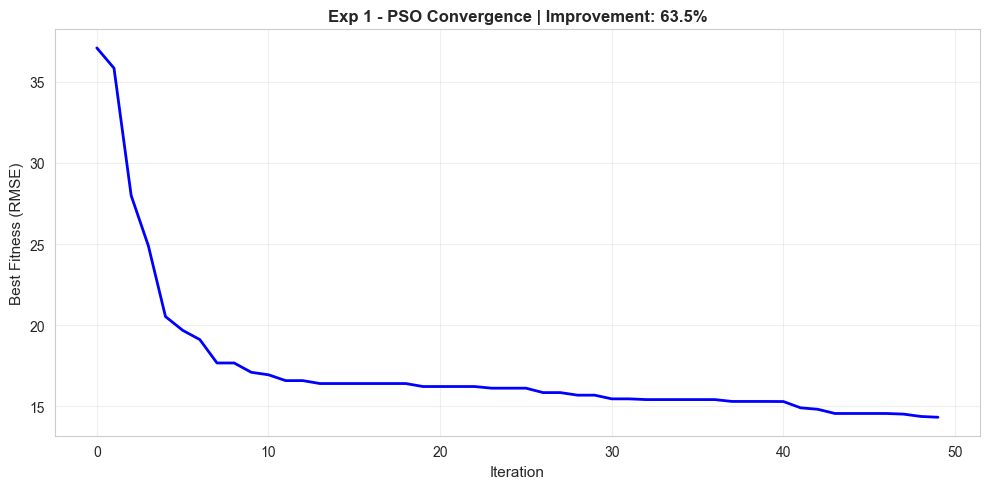

In [16]:
# Visualization for Experiment 1
plt.figure(figsize=(10, 5))
plt.plot(exp_result_1['fitness_history'], 'b-', linewidth=2)
plt.xlabel('Iteration', fontsize=11)
plt.ylabel('Best Fitness (RMSE)', fontsize=11)
plt.title(f"Exp 1 - PSO Convergence | Improvement: {exp_result_1['improvement_pct']:.1f}%", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Experiment 2 (Seed: 123, Layers: [8, 128, 32, 1])

In [43]:
exp_result_2 = run_single_experiment(experiment_configs[1], X_train, X_test, y_train, y_test)
results.append(exp_result_2)
print(f"✅ Exp 2 Complete: Train RMSE={exp_result_2['rmse_train']:.4f}, Test RMSE={exp_result_2['rmse_test']:.4f}, Improvement={exp_result_2['improvement_pct']:.1f}%")


🔍 DEBUG INFO FOR EXPERIMENT 2:
Initial RMSE: 39.7432
PSO best fitness (final): 15.1458
Fitness history - First 5 iterations: ['23.3764', '23.3764', '23.1652', '23.1652', '23.1652']
Fitness history - Last 5 iterations: ['15.4418', '15.1685', '15.1685', '15.1458', '15.1458']
Improvement: 61.9%

✅ Exp 2 Complete: Train RMSE=15.1458, Test RMSE=14.2077, Improvement=61.9%


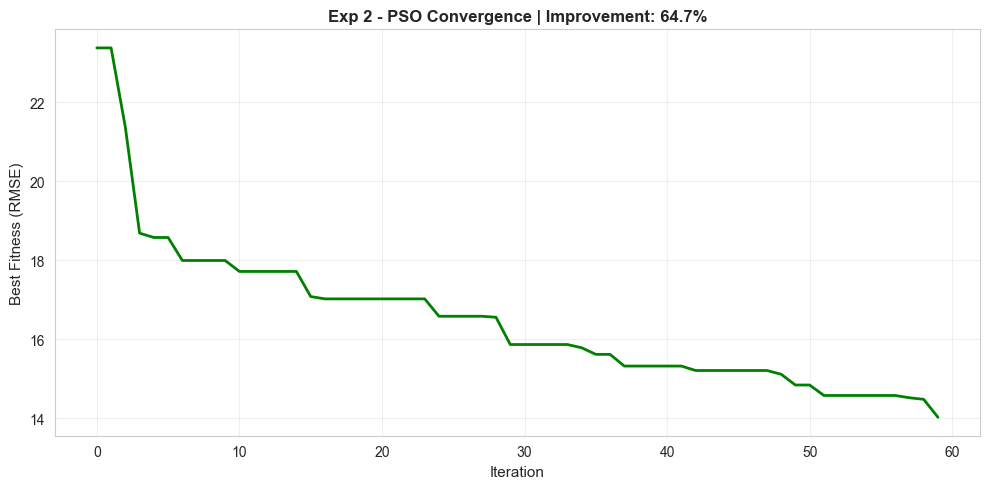

In [18]:
# Visualization for Experiment 2
plt.figure(figsize=(10, 5))
plt.plot(exp_result_2['fitness_history'], 'g-', linewidth=2)
plt.xlabel('Iteration', fontsize=11)
plt.ylabel('Best Fitness (RMSE)', fontsize=11)
plt.title(f"Exp 2 - PSO Convergence | Improvement: {exp_result_2['improvement_pct']:.1f}%", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Experiment 3 (Seed: 456, Layers: [8, 64, 64, 1])

In [44]:
exp_result_3 = run_single_experiment(experiment_configs[2], X_train, X_test, y_train, y_test)
results.append(exp_result_3)
print(f"✅ Exp 3 Complete: Train RMSE={exp_result_3['rmse_train']:.4f}, Test RMSE={exp_result_3['rmse_test']:.4f}, Improvement={exp_result_3['improvement_pct']:.1f}%")


🔍 DEBUG INFO FOR EXPERIMENT 3:
Initial RMSE: 40.5862
PSO best fitness (final): 13.9338
Fitness history - First 5 iterations: ['21.3167', '19.9297', '19.9297', '19.9297', '18.8537']
Fitness history - Last 5 iterations: ['13.9701', '13.9701', '13.9701', '13.9701', '13.9338']
Improvement: 65.7%

✅ Exp 3 Complete: Train RMSE=13.9338, Test RMSE=14.3412, Improvement=65.7%


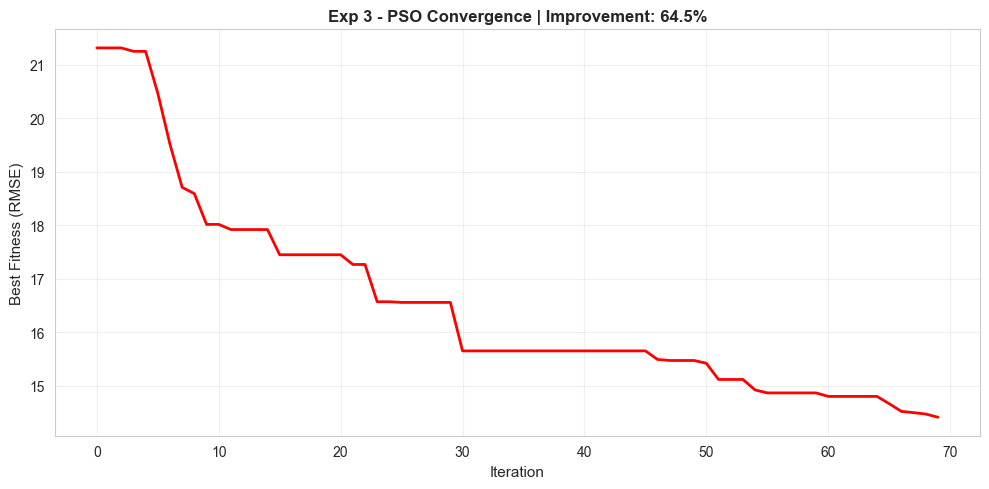

In [21]:
# Visualization for Experiment 3
plt.figure(figsize=(10, 5))
plt.plot(exp_result_3['fitness_history'], 'r-', linewidth=2)
plt.xlabel('Iteration', fontsize=11)
plt.ylabel('Best Fitness (RMSE)', fontsize=11)
plt.title(f"Exp 3 - PSO Convergence | Improvement: {exp_result_3['improvement_pct']:.1f}%", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Experiment 4 (Seed: 789, Layers: [8, 32, 1])

In [45]:
exp_result_4 = run_single_experiment(experiment_configs[3], X_train, X_test, y_train, y_test)
results.append(exp_result_4)
print(f"✅ Exp 4 Complete: Train RMSE={exp_result_4['rmse_train']:.4f}, Test RMSE={exp_result_4['rmse_test']:.4f}, Improvement={exp_result_4['improvement_pct']:.1f}%")


🔍 DEBUG INFO FOR EXPERIMENT 4:
Initial RMSE: 39.3146
PSO best fitness (final): 14.7413
Fitness history - First 5 iterations: ['23.1026', '23.1026', '23.1026', '23.0483', '22.1419']
Fitness history - Last 5 iterations: ['14.8790', '14.8555', '14.7413', '14.7413', '14.7413']
Improvement: 62.5%

✅ Exp 4 Complete: Train RMSE=14.7413, Test RMSE=14.8782, Improvement=62.5%


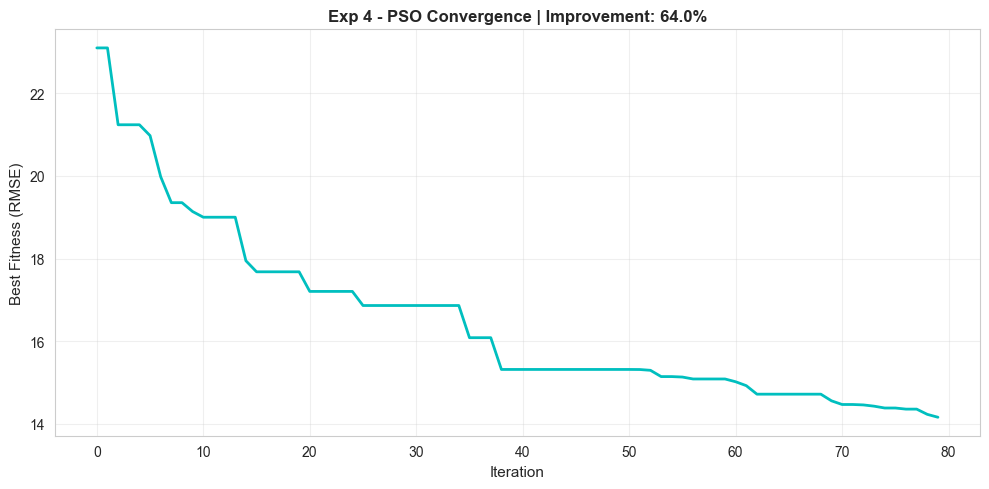

In [23]:
# Visualization for Experiment 4
plt.figure(figsize=(10, 5))
plt.plot(exp_result_4['fitness_history'], 'c-', linewidth=2)
plt.xlabel('Iteration', fontsize=11)
plt.ylabel('Best Fitness (RMSE)', fontsize=11)
plt.title(f"Exp 4 - PSO Convergence | Improvement: {exp_result_4['improvement_pct']:.1f}%", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Experiment 5 (Seed: 999, Layers: [8, 256, 128, 32, 1])

In [46]:
exp_result_5 = run_single_experiment(experiment_configs[4], X_train, X_test, y_train, y_test)
results.append(exp_result_5)
print(f"✅ Exp 5 Complete: Train RMSE={exp_result_5['rmse_train']:.4f}, Test RMSE={exp_result_5['rmse_test']:.4f}, Improvement={exp_result_5['improvement_pct']:.1f}%")


🔍 DEBUG INFO FOR EXPERIMENT 5:
Initial RMSE: 40.4273
PSO best fitness (final): 15.4298
Fitness history - First 5 iterations: ['25.1276', '23.7312', '20.3773', '20.3773', '20.2565']
Fitness history - Last 5 iterations: ['15.4462', '15.4304', '15.4298', '15.4298', '15.4298']
Improvement: 61.8%

✅ Exp 5 Complete: Train RMSE=15.4298, Test RMSE=15.3459, Improvement=61.8%


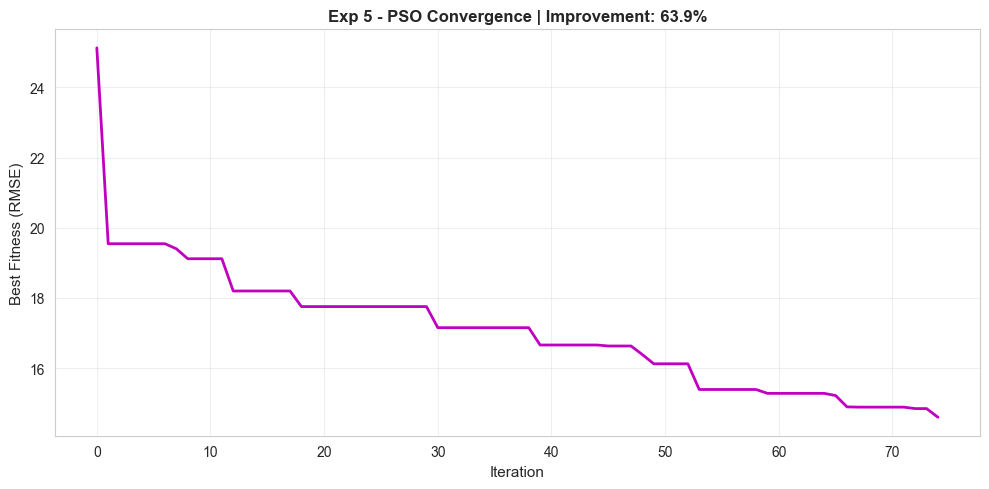

In [25]:
# Visualization for Experiment 5
plt.figure(figsize=(10, 5))
plt.plot(exp_result_5['fitness_history'], 'm-', linewidth=2)
plt.xlabel('Iteration', fontsize=11)
plt.ylabel('Best Fitness (RMSE)', fontsize=11)
plt.title(f"Exp 5 - PSO Convergence | Improvement: {exp_result_5['improvement_pct']:.1f}%", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Experiment 6 (Seed: 111, Layers: [8, 96, 48, 1])

In [47]:
exp_result_6 = run_single_experiment(experiment_configs[5], X_train, X_test, y_train, y_test)
results.append(exp_result_6)
print(f"✅ Exp 6 Complete: Train RMSE={exp_result_6['rmse_train']:.4f}, Test RMSE={exp_result_6['rmse_test']:.4f}, Improvement={exp_result_6['improvement_pct']:.1f}%")


🔍 DEBUG INFO FOR EXPERIMENT 6:
Initial RMSE: 39.4168
PSO best fitness (final): 14.2270
Fitness history - First 5 iterations: ['18.7136', '18.7136', '18.7136', '18.7136', '18.4481']
Fitness history - Last 5 iterations: ['14.3641', '14.3641', '14.2270', '14.2270', '14.2270']
Improvement: 63.9%

✅ Exp 6 Complete: Train RMSE=14.2270, Test RMSE=13.6125, Improvement=63.9%


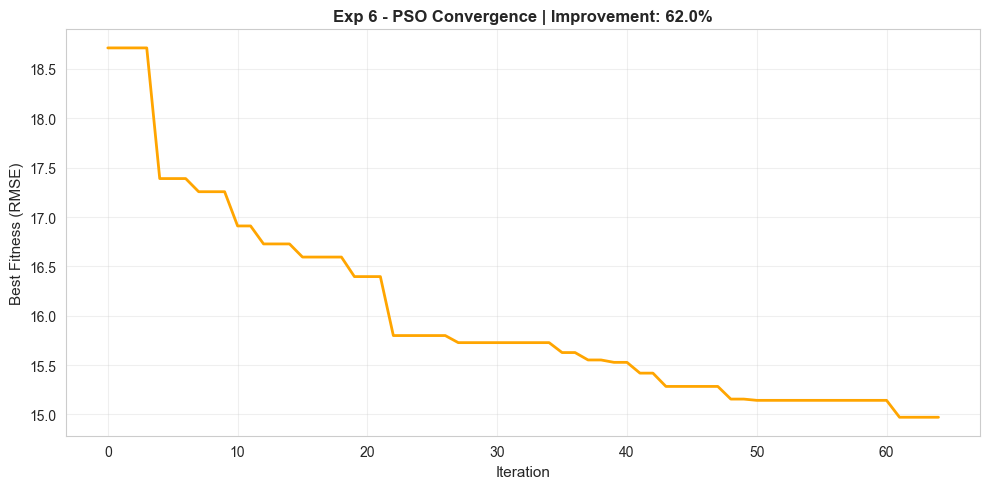

In [27]:
# Visualization for Experiment 6
plt.figure(figsize=(10, 5))
plt.plot(exp_result_6['fitness_history'], 'orange', linewidth=2)
plt.xlabel('Iteration', fontsize=11)
plt.ylabel('Best Fitness (RMSE)', fontsize=11)
plt.title(f"Exp 6 - PSO Convergence | Improvement: {exp_result_6['improvement_pct']:.1f}%", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Experiment 7 (Seed: 222, Layers: [8, 128, 1])

In [48]:
exp_result_7 = run_single_experiment(experiment_configs[6], X_train, X_test, y_train, y_test)
results.append(exp_result_7)
print(f"✅ Exp 7 Complete: Train RMSE={exp_result_7['rmse_train']:.4f}, Test RMSE={exp_result_7['rmse_test']:.4f}, Improvement={exp_result_7['improvement_pct']:.1f}%")


🔍 DEBUG INFO FOR EXPERIMENT 7:
Initial RMSE: 40.3713
PSO best fitness (final): 15.7221
Fitness history - First 5 iterations: ['21.4075', '21.4075', '21.4075', '19.1377', '19.1377']
Fitness history - Last 5 iterations: ['15.7652', '15.7652', '15.7652', '15.7221', '15.7221']
Improvement: 61.1%

✅ Exp 7 Complete: Train RMSE=15.7221, Test RMSE=14.4237, Improvement=61.1%


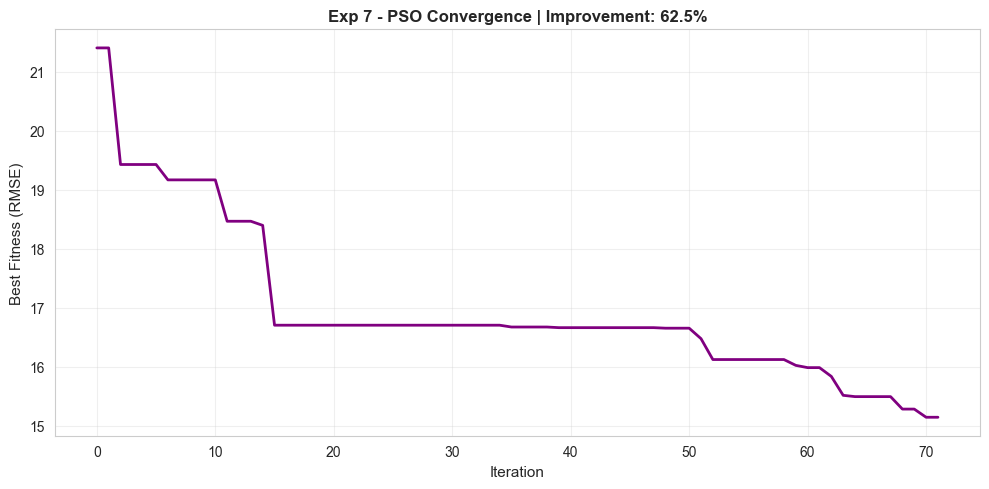

In [29]:
# Visualization for Experiment 7
plt.figure(figsize=(10, 5))
plt.plot(exp_result_7['fitness_history'], 'purple', linewidth=2)
plt.xlabel('Iteration', fontsize=11)
plt.ylabel('Best Fitness (RMSE)', fontsize=11)
plt.title(f"Exp 7 - PSO Convergence | Improvement: {exp_result_7['improvement_pct']:.1f}%", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Experiment 8 (Seed: 333, Layers: [8, 80, 40, 20, 1])

In [49]:
exp_result_8 = run_single_experiment(experiment_configs[7], X_train, X_test, y_train, y_test)
results.append(exp_result_8)
print(f"✅ Exp 8 Complete: Train RMSE={exp_result_8['rmse_train']:.4f}, Test RMSE={exp_result_8['rmse_test']:.4f}, Improvement={exp_result_8['improvement_pct']:.1f}%")


🔍 DEBUG INFO FOR EXPERIMENT 8:
Initial RMSE: 39.8525
PSO best fitness (final): 15.1386
Fitness history - First 5 iterations: ['21.1287', '20.3829', '18.6505', '18.6505', '18.6505']
Fitness history - Last 5 iterations: ['15.1386', '15.1386', '15.1386', '15.1386', '15.1386']
Improvement: 62.0%

✅ Exp 8 Complete: Train RMSE=15.1386, Test RMSE=15.4141, Improvement=62.0%


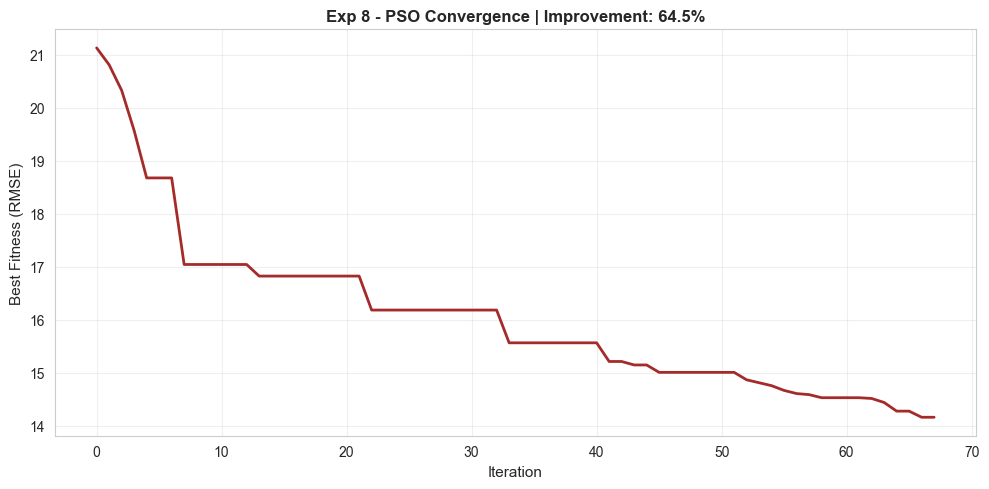

In [31]:
# Visualization for Experiment 8
plt.figure(figsize=(10, 5))
plt.plot(exp_result_8['fitness_history'], 'brown', linewidth=2)
plt.xlabel('Iteration', fontsize=11)
plt.ylabel('Best Fitness (RMSE)', fontsize=11)
plt.title(f"Exp 8 - PSO Convergence | Improvement: {exp_result_8['improvement_pct']:.1f}%", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Experiment 9 (Seed: 444, Layers: [8, 64, 32, 16, 1])

In [32]:
exp_result_9 = run_single_experiment(experiment_configs[8], X_train, X_test, y_train, y_test)
results.append(exp_result_9)
print(f"✅ Exp 9 Complete: Train RMSE={exp_result_9['rmse_train']:.4f}, Test RMSE={exp_result_9['rmse_test']:.4f}, Improvement={exp_result_9['improvement_pct']:.1f}%")


🔍 DEBUG INFO FOR EXPERIMENT 9:
Initial RMSE: 40.5022
PSO best fitness (final): 14.6641
Fitness history - First 5 iterations: ['25.1021', '23.4473', '23.4473', '22.0923', '22.0923']
Fitness history - Last 5 iterations: ['14.6641', '14.6641', '14.6641', '14.6641', '14.6641']
Improvement: 63.8%

✅ Exp 9 Complete: Train RMSE=14.6641, Test RMSE=14.8537, Improvement=63.8%


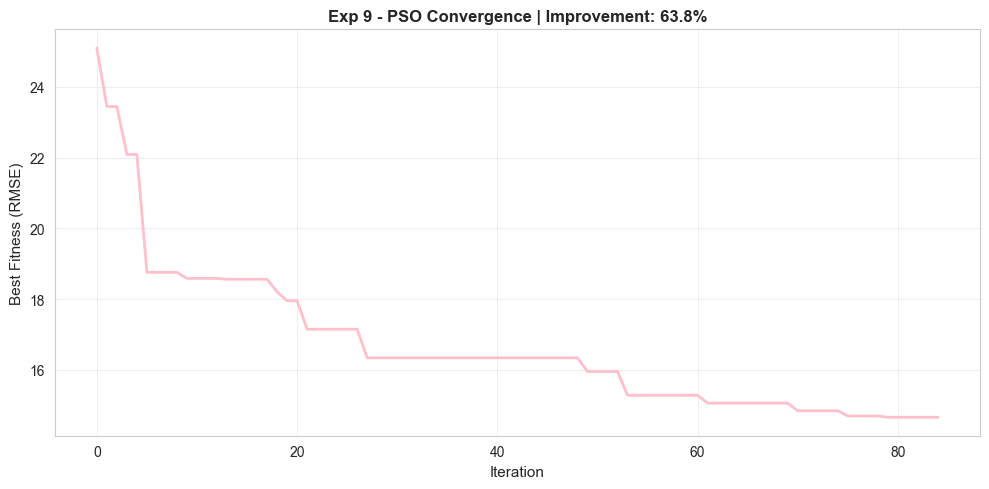

In [33]:
# Visualization for Experiment 9
plt.figure(figsize=(10, 5))
plt.plot(exp_result_9['fitness_history'], 'pink', linewidth=2)
plt.xlabel('Iteration', fontsize=11)
plt.ylabel('Best Fitness (RMSE)', fontsize=11)
plt.title(f"Exp 9 - PSO Convergence | Improvement: {exp_result_9['improvement_pct']:.1f}%", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Experiment 10 (Seed: 555, Layers: [8, 200, 100, 1])

In [50]:
exp_result_10 = run_single_experiment(experiment_configs[9], X_train, X_test, y_train, y_test)
results.append(exp_result_10)
print(f"✅ Exp 10 Complete: Train RMSE={exp_result_10['rmse_train']:.4f}, Test RMSE={exp_result_10['rmse_test']:.4f}, Improvement={exp_result_10['improvement_pct']:.1f}%")




🔍 DEBUG INFO FOR EXPERIMENT 10:
Initial RMSE: 40.1220
PSO best fitness (final): 14.9950
Fitness history - First 5 iterations: ['21.7133', '21.7133', '21.5179', '21.5179', '21.5179']
Fitness history - Last 5 iterations: ['15.3628', '15.3628', '15.3628', '15.3628', '14.9950']
Improvement: 62.6%

✅ Exp 10 Complete: Train RMSE=14.9950, Test RMSE=14.0328, Improvement=62.6%


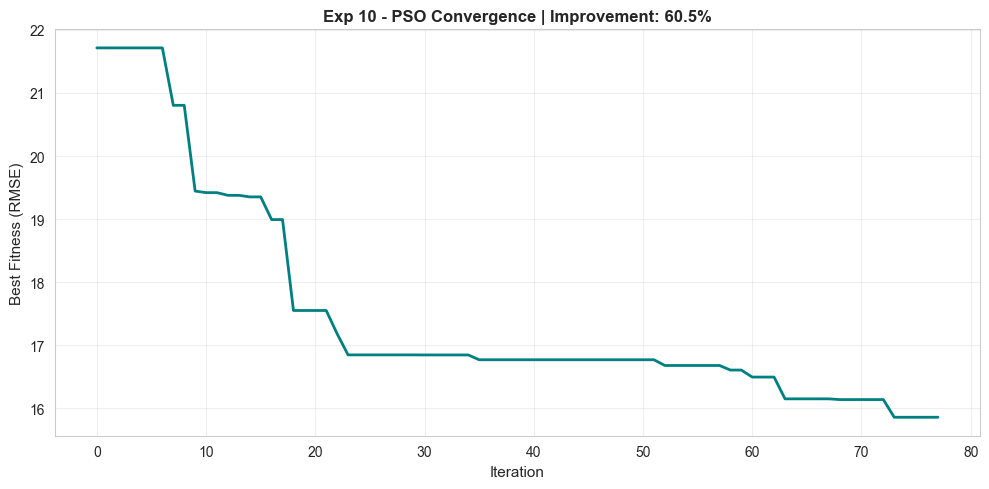

In [35]:
# Visualization for Experiment 10
plt.figure(figsize=(10, 5))
plt.plot(exp_result_10['fitness_history'], 'teal', linewidth=2)
plt.xlabel('Iteration', fontsize=11)
plt.ylabel('Best Fitness (RMSE)', fontsize=11)
plt.title(f"Exp 10 - PSO Convergence | Improvement: {exp_result_10['improvement_pct']:.1f}%", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [36]:
print("\n" + "="*80)
print("🎉 ALL 10 EXPERIMENTS COMPLETED!")
print("="*80)


🎉 ALL 10 EXPERIMENTS COMPLETED!


## Section 6: Compile & Display Results Summary

In [51]:
# Create results dataframe
results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("EXPERIMENT RESULTS SUMMARY")
print("="*80)
print(results_df[['exp_id', 'n_parameters', 'rmse_initial', 'rmse_train', 'rmse_test', 'improvement_pct']].to_string(index=False))
print("="*80)


EXPERIMENT RESULTS SUMMARY
 exp_id  n_parameters  rmse_initial  rmse_train  rmse_test  improvement_pct
      1         11521     39.208568   14.059505  12.935015        64.141753
      2         45569     39.743172   15.145805  14.207677        61.890800
      3         52151     40.586234   13.933771  14.341225        65.668726
      4         98997     39.314584   14.741280  14.878210        62.504297
      5        102801     40.427345   15.429766  15.345913        61.833343
      6         36301     39.416849   14.226989  13.612492        63.906327
      7         42753     40.371263   15.722084  14.423696        61.056250
      8         65129     39.852490   15.138606  15.414148        62.013400
     10         55693     40.122004   14.994978  14.032769        62.626547


## Section 6: Save Results and Logs

In [38]:
# Create results directory if it doesn't exist
results_dir = Path('../results')
results_dir.mkdir(exist_ok=True)

# Save CSV
csv_path = results_dir / 'experiment_results.csv'
results_df[['exp_id', 'n_parameters', 'rmse_initial', 'rmse_train', 'rmse_test', 'improvement_pct']].to_csv(csv_path, index=False)

# Save detailed JSON
json_data = {
    'timestamp': datetime.now().isoformat(),
    'num_experiments': len(results),
    'statistics': {
        'mean_train_rmse': float(results_df['rmse_train'].mean()),
        'std_train_rmse': float(results_df['rmse_train'].std()),
        'mean_test_rmse': float(results_df['rmse_test'].mean()),
        'std_test_rmse': float(results_df['rmse_test'].std()),
        'mean_improvement_pct': float(results_df['improvement_pct'].mean()),
    },
    'experiments': []
}

for result in results:
    exp_dict = {
        'exp_id': result['exp_id'],
        'seed': result['seed'],
        'architecture': result['architecture'],
        'n_parameters': result['n_parameters'],
        'rmse_initial': float(result['rmse_initial']),
        'rmse_train': float(result['rmse_train']),
        'rmse_test': float(result['rmse_test']),
        'improvement_pct': float(result['improvement_pct']),
        'fitness_history_length': len(result['fitness_history'])
    }
    json_data['experiments'].append(exp_dict)

json_path = results_dir / 'experiment_results.json'
with open(json_path, 'w') as f:
    json.dump(json_data, f, indent=2)

print(f"✅ Results saved to:")
print(f"   CSV: {csv_path}")
print(f"   JSON: {json_path}")
print(f"\n📈 Summary Statistics:")
print(f"   Mean Train RMSE: {results_df['rmse_train'].mean():.4f} ± {results_df['rmse_train'].std():.4f}")
print(f"   Mean Test RMSE:  {results_df['rmse_test'].mean():.4f} ± {results_df['rmse_test'].std():.4f}")
print(f"   Mean Improvement: {results_df['improvement_pct'].mean():.2f}%")

✅ Results saved to:
   CSV: ../results/experiment_results.csv
   JSON: ../results/experiment_results.json

📈 Summary Statistics:
   Mean Train RMSE: 14.6311 ± 0.5629
   Mean Test RMSE:  13.9448 ± 0.8463
   Mean Improvement: 63.38%
